In [2]:
%pip install scikit-learn
%pip install scikit-learn scipy

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.1 MB 9.9 MB/s eta 0:00:02
   ------------- -------------------------- 3.7/11.1 MB 11.6 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.1 MB 11.9 MB/s eta 0:00:01
   ---------------------------- ----------- 7.9/11.1 MB 10.9 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.1 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 10.1 MB/s eta 0:00:01
   -----------


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize

In [4]:
df = pd.read_csv('sandiego.csv')

In [5]:
# Variables relevantes
variables = [
    'room_type', 'host_acceptance_rate', 'host_response_rate',
    'review_scores_location', 'review_scores_cleanliness', 'price',
    'availability_365', 'number_of_reviews', 'reviews_per_month',
    'review_scores_communication', 'host_id', 'host_is_superhost',
    'host_total_listings_count', 'review_scores_value',
    'accommodates', 'bedrooms'
]

df = df[variables]

In [6]:
# Limpiar y convertir datos
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float)
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['host_is_superhost'] = df['host_is_superhost'].fillna(df['host_is_superhost'].mode()[0])
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Maugo\AppData\Local\Temp\ipykernel_28568\3109538298.py:4: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


In [7]:
# Imputar nulos con la media
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].mean(), inplace=True)

C:\Users\Maugo\AppData\Local\Temp\ipykernel_28568\4164296490.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [8]:
# Winsorization de variables numéricas
for col in df.select_dtypes(include='number').columns:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])


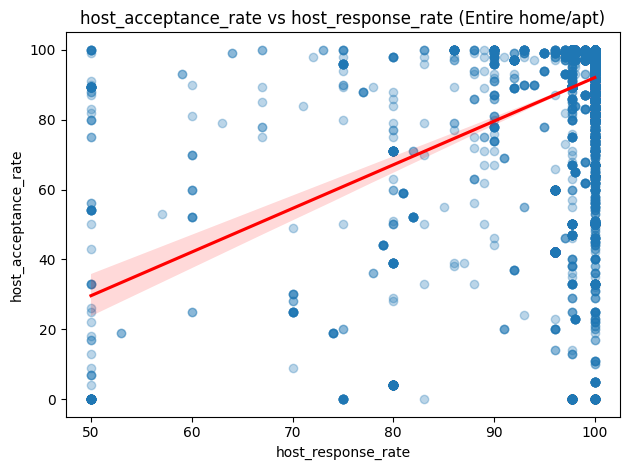

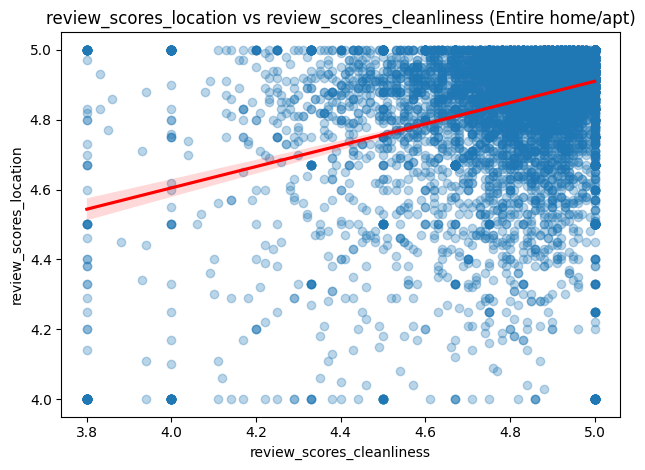

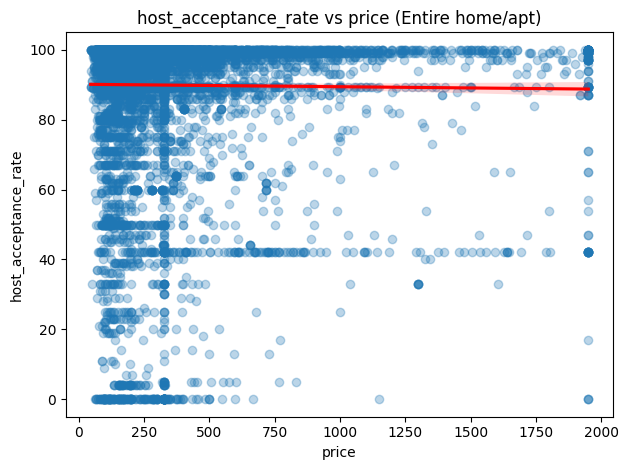

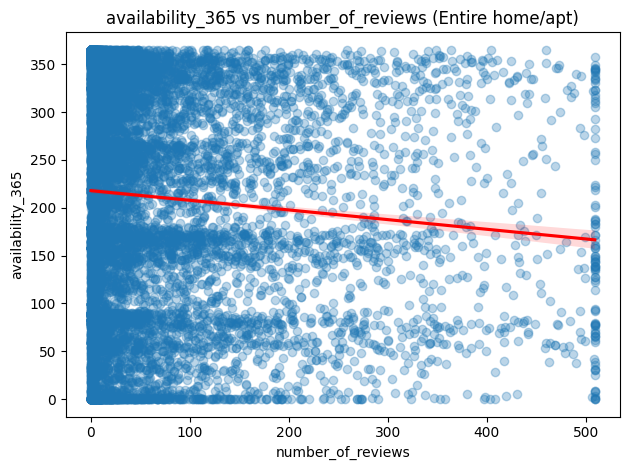

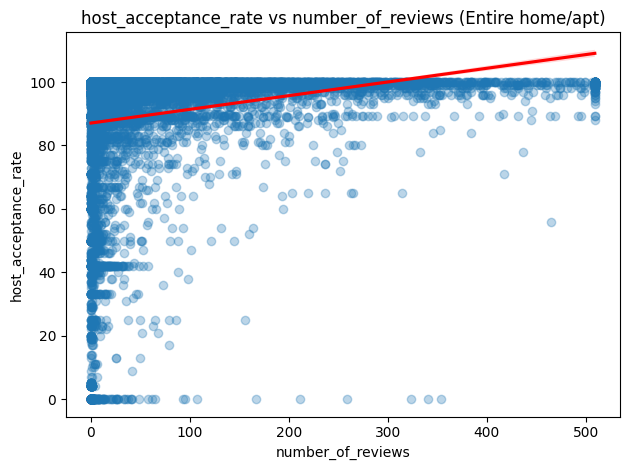

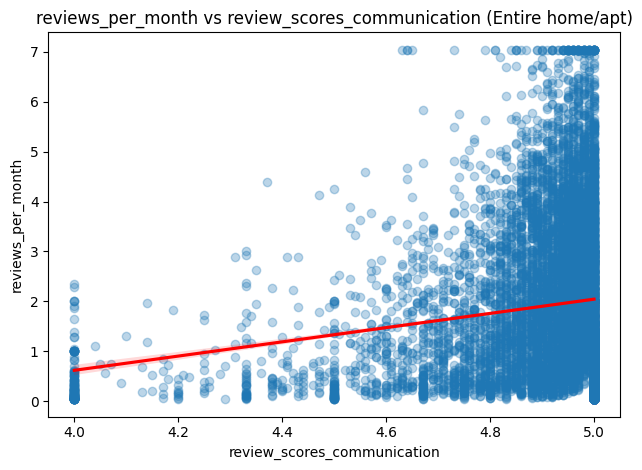

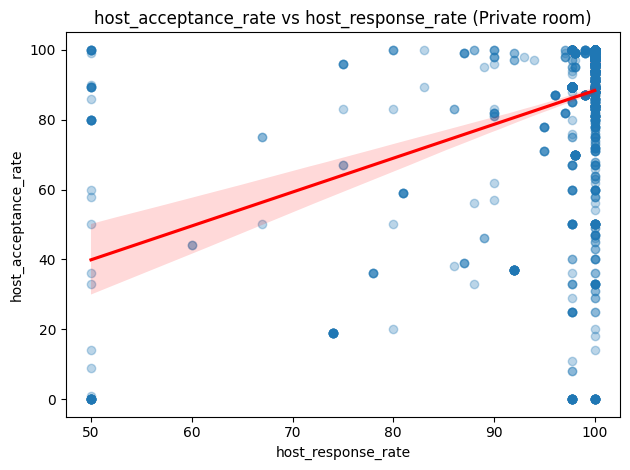

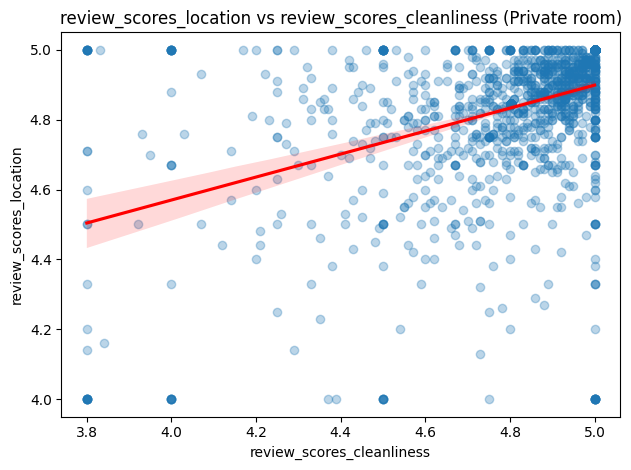

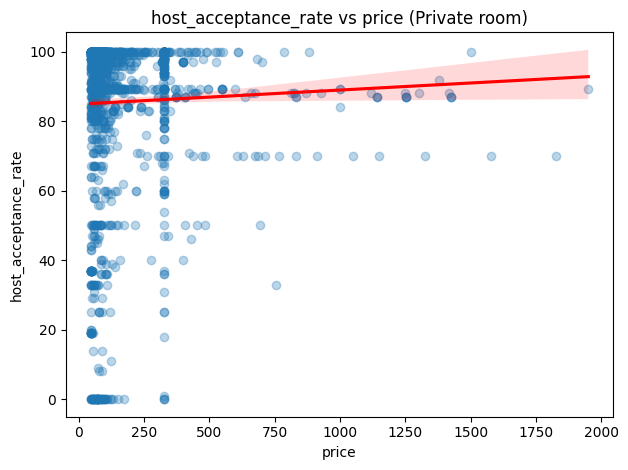

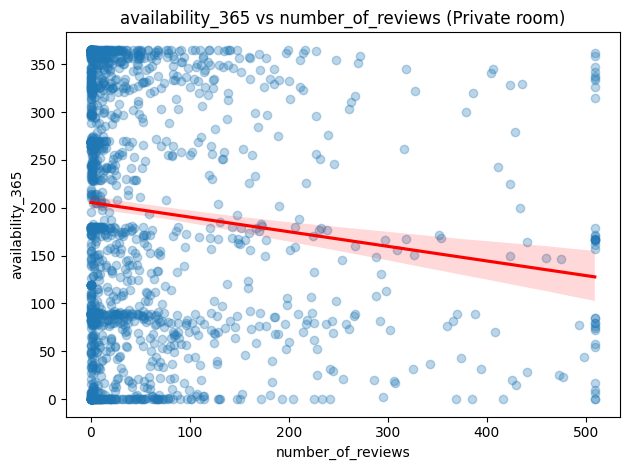

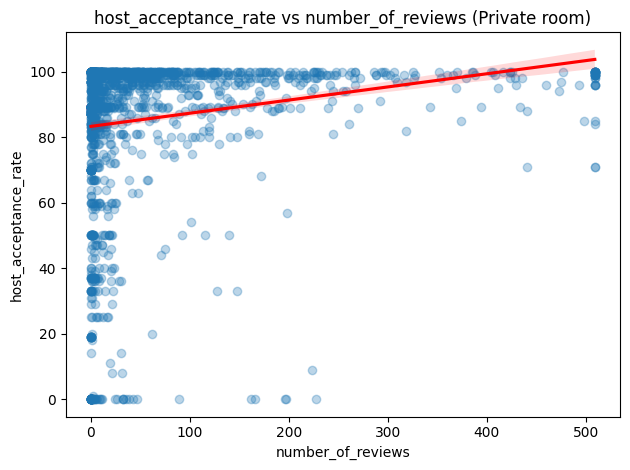

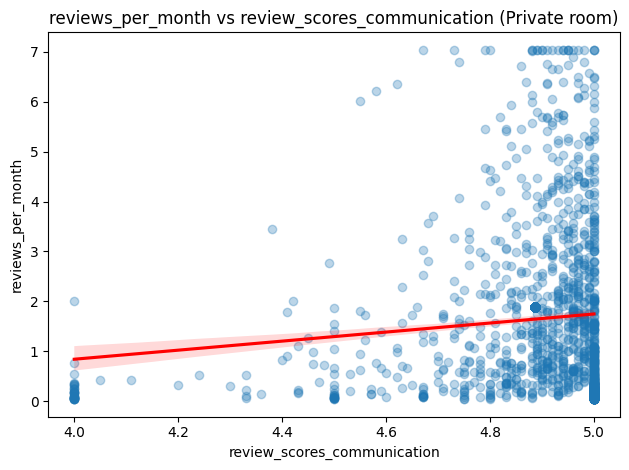

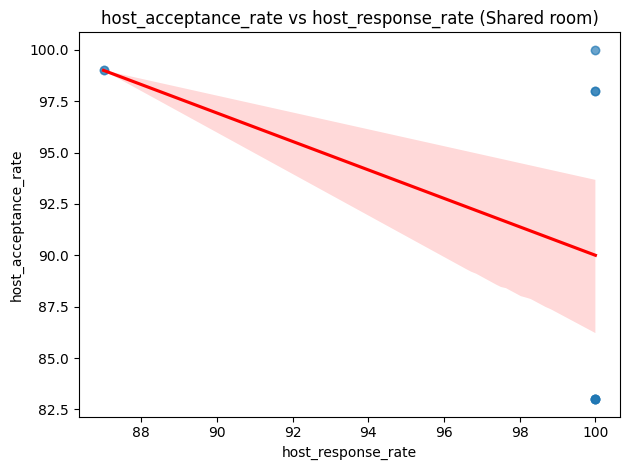

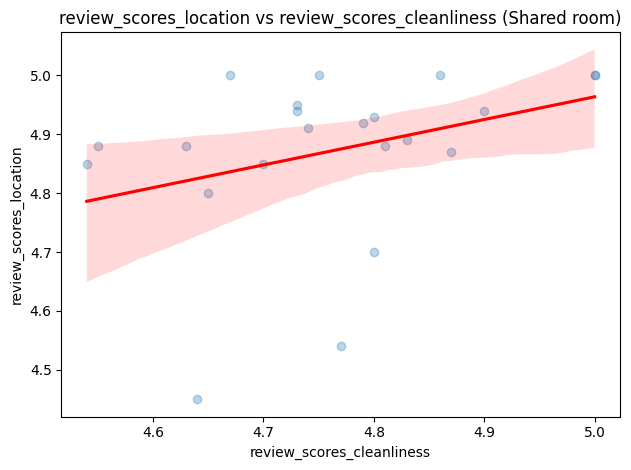

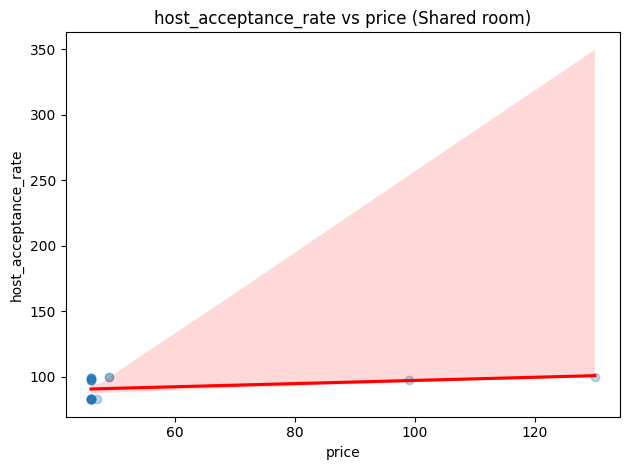

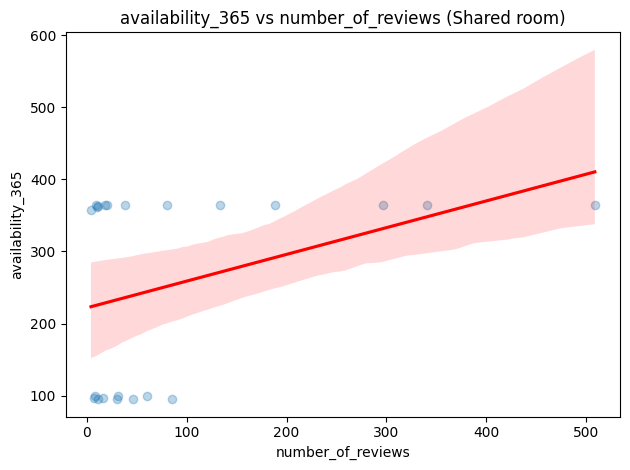

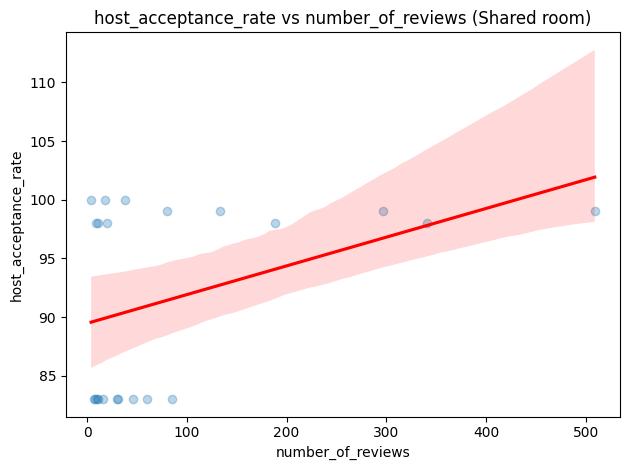

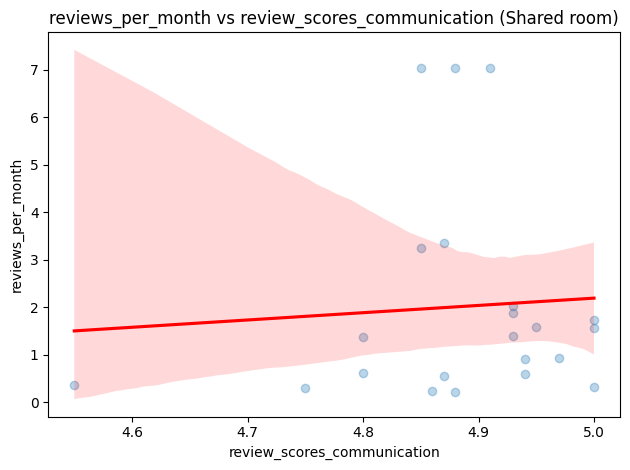

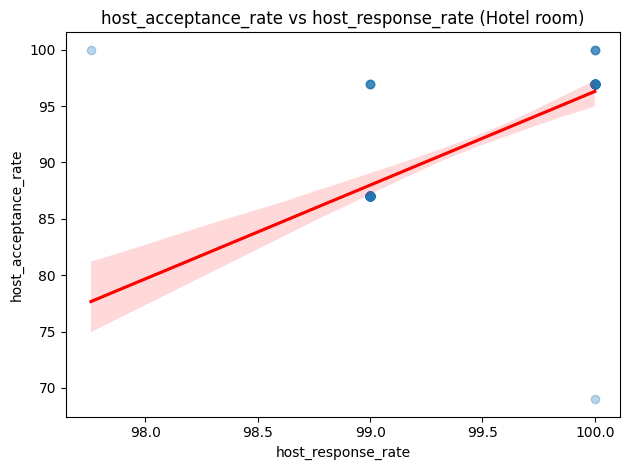

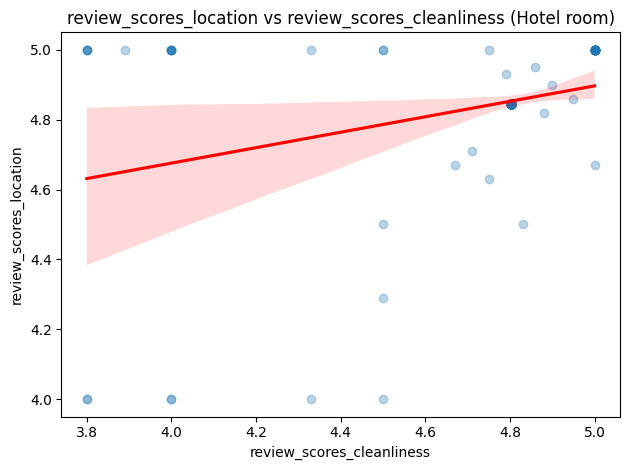

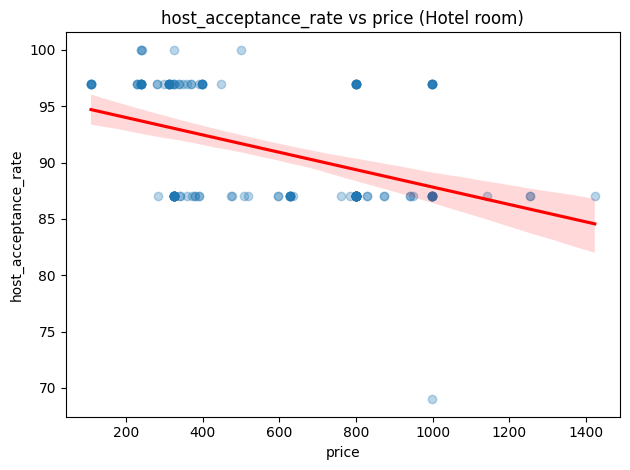

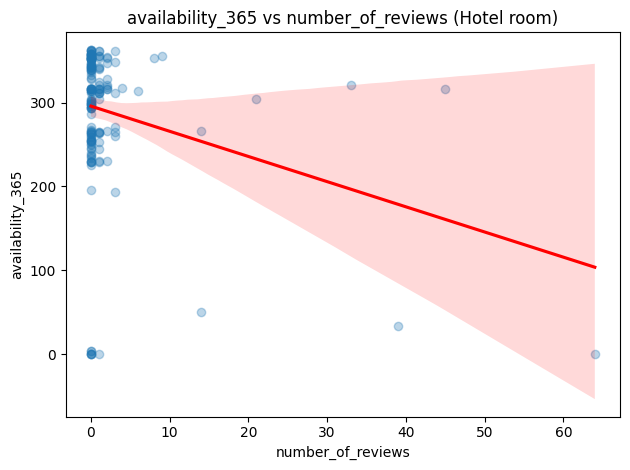

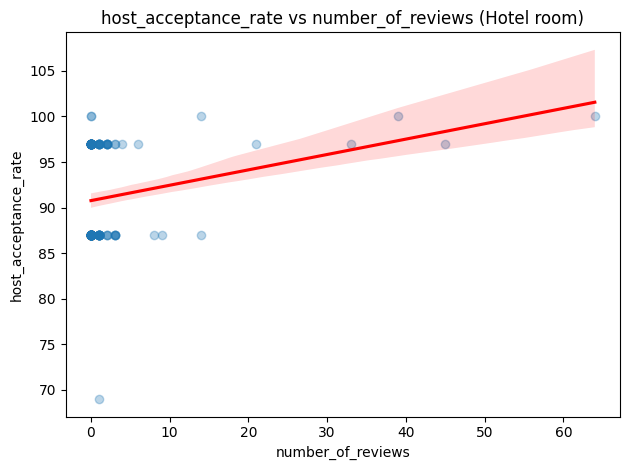

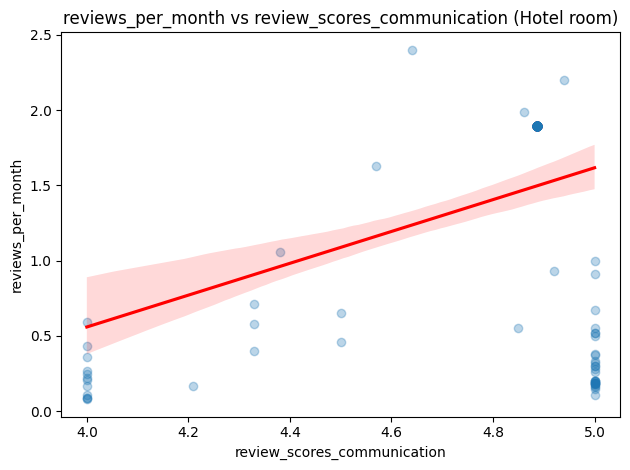

In [9]:

# --- 2. ANÁLISIS DE CORRELACIÓN PARA 4 TIPOS DE HABITACIÓN ---
tipos_habitacion = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']
pares_variables = [
    ('host_acceptance_rate', 'host_response_rate'),
    ('review_scores_location', 'review_scores_cleanliness'),
    ('host_acceptance_rate', 'price'),
    ('availability_365', 'number_of_reviews'),
    ('host_acceptance_rate', 'number_of_reviews'),
    ('reviews_per_month', 'review_scores_communication')
]
for room in tipos_habitacion:
    df_room = df[df['room_type'] == room]
    for dep, indep in pares_variables:
        sns.regplot(data=df_room, x=indep, y=dep, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
        plt.title(f'{dep} vs {indep} ({room})')
        plt.xlabel(indep)
        plt.ylabel(dep)
        plt.tight_layout()
        plt.show()

In [10]:
# --- 3. MODELO CON MAYOR CORRELACIÓN POR TIPO DE HABITACIÓN ---
variables_corr = df.select_dtypes(include='number').columns.tolist()
mejores_modelos = {}

for room in tipos_habitacion:
    df_room = df[df['room_type'] == room][variables_corr]
    corr_matrix = df_room.corr()

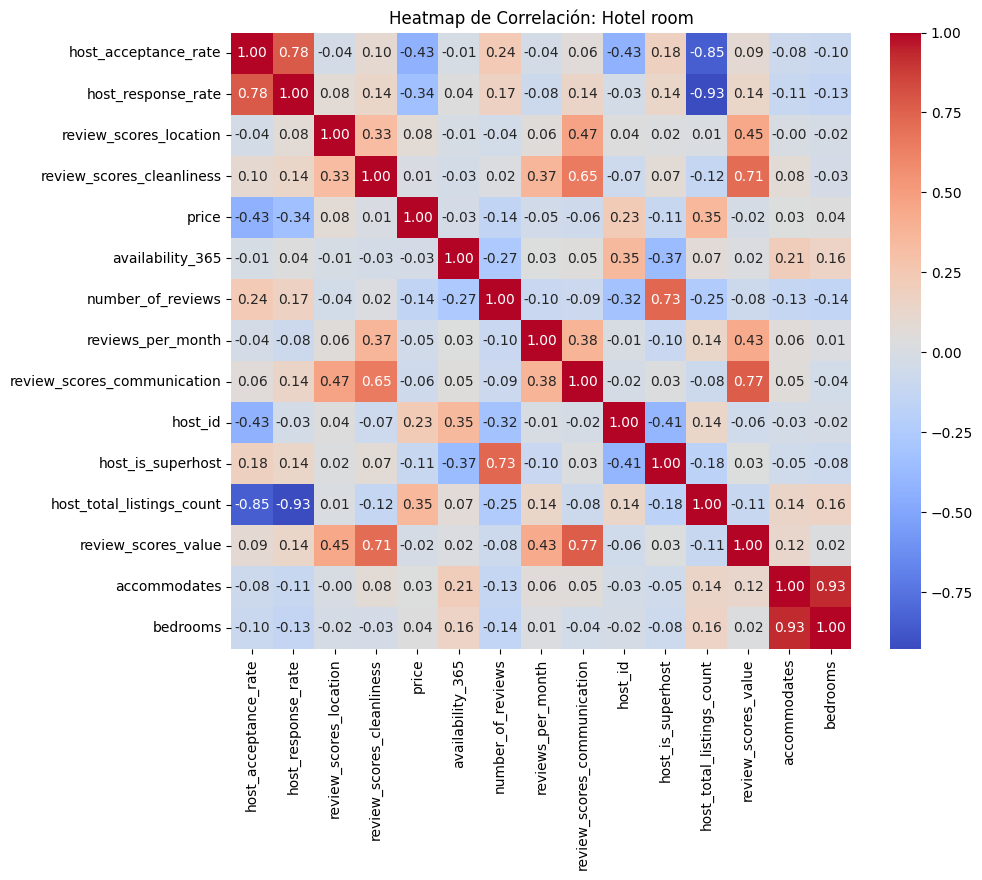

In [11]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Heatmap de Correlación: {room}')
plt.show()

In [12]:
# Buscar par con mayor correlación absoluta
corr_pairs = corr_matrix.abs().unstack()
corr_pairs = corr_pairs[corr_pairs < 1]
max_corr_pair = corr_pairs.idxmax()

In [13]:
# Modelo lineal
X = df_room[[max_corr_pair[1]]].values
y = df_room[max_corr_pair[0]].values
model = LinearRegression().fit(X, y)
mejores_modelos[room] = {
        'mejor_par': max_corr_pair,
        'r2': model.score(X, y),
        'coef': model.coef_[0],
        'intercept': model.intercept_
    }

In [14]:
# --- 4. TABLA CON 10 CORRELACIONES MÁS ALTAS POR TIPO ---
top_corrs_por_tipo = {}

for room in tipos_habitacion:
    df_room = df[df['room_type'] == room][variables_corr]
    corr_matrix = df_room.corr()

    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']
    corr_pairs['|Correlación|'] = corr_pairs['Correlación'].abs()
    corr_pairs['R2'] = corr_pairs['|Correlación|'] ** 2

    top_corrs = corr_pairs.sort_values(by='|Correlación|', ascending=False).head(10)
    top_corrs_por_tipo[room] = top_corrs

In [15]:
# --- 5. REGRESIÓN LINEAL MÚLTIPLE PARA CADA VARIABLE DEPENDIENTE ---
df_modelo = df.copy()
df_modelo = pd.get_dummies(df_modelo, columns=['room_type'], drop_first=True)

resultados_modelos = {}

for target in [
    'host_id', 'host_acceptance_rate', 'host_is_superhost',
    'host_total_listings_count', 'accommodates', 'bedrooms',
    'price', 'review_scores_value', 'reviews_per_month'
]:
    X = df_modelo.drop(columns=[target])
    y = df_modelo[target]
    model = LinearRegression().fit(X, y)
    resultados_modelos[target] = {
        'r2': model.score(X, y),
        'coeficientes': pd.Series(model.coef_, index=X.columns)
    }

resultados_modelos['price']  # ejemplo mostrado de modelo de precio

{'r2': 0.4608295202115489,
 'coeficientes': host_acceptance_rate          -5.820645e-02
 host_response_rate            -6.194177e-01
 review_scores_location         1.843676e+02
 review_scores_cleanliness      1.307102e+02
 availability_365               2.347257e-03
 number_of_reviews             -2.762821e-02
 reviews_per_month             -1.689420e+01
 review_scores_communication   -4.788878e+01
 host_id                       -1.587870e-09
 host_is_superhost              8.346679e+00
 host_total_listings_count      4.436689e-02
 review_scores_value           -9.932401e+01
 accommodates                   3.301207e+01
 bedrooms                       7.067991e+01
 room_type_Hotel room           8.339904e+01
 room_type_Private room         4.127403e+00
 room_type_Shared room         -6.185366e+01
 dtype: float64}